# Introduction to `DESeq2`

This notebook serves as a tutorial for using the DESeq2 package. Please be sure to consult the excellent vignette provided by the DESeq2 package. Hopefully, we will also get a chance to review the edgeR package (which also has a very nice vignette which I suggest that you review)

## Load packages

Load requisite R packages. 

In [1]:
library(DESeq2)
library(tools)
library(limma)
library(qvalue)
library(dplyr)
options(width=100)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The following objects are maske

## Import Data

The first step to any analysis is to import the data into an analysis ready format. The latter depends on the requirements of the package used for the analysis. 

For this analysis, we will use the DESeq2::DESeqDataSetFromHTSeqCount. This function allows you to import count files generated by HTSeq directly into R. If you use a program other than HTSeq, you should use the DESeq2::DESeqDataSetFromMatrix function.

Let's review the three main arguments of DESeq2::DESeqDataSetFromHTSeqCount: sampleTable, directory and design


In [2]:
#? DESeqDataSetFromHTSeqCount

First set the directory under which the HTSeq count files are stored

In [3]:
datadir<-"/home/jovyan/work/2017-HTS-materials/Materials/Statistics/08032017/Data/2015"

Next, put the filenames into a data frame

In [4]:
phdata<-data.frame(fname=list.files(path=datadir,pattern="*.csv"),stringsAsFactors=FALSE)
head(phdata)

fname
1 7A_E.csv
2 7A_G.csv
3 7A_K.csv
4 7A_N.csv
5 7A_P.csv
6 7B_E.csv

It is always a good idea to check the dimension of the file you have read in

In [5]:
dim(phdata)

[1] 30  1

Extract the label from the filename. Why should one reorder columns? See DESeq2 help file

In [6]:
phdata <- phdata %>% transmute(sample=substr(fname,1,4),fname)
head(phdata)

sample    fname
1   7A_E 7A_E.csv
2   7A_G 7A_G.csv
3   7A_K 7A_K.csv
4   7A_N 7A_N.csv
5   7A_P 7A_P.csv
6   7B_E 7B_E.csv

For any analysis, you should have a manifest file that maps the file names (containing the counts) to the phenotypic  and experimental condition for the sample. This file should be validated and put under strict vesrion control.

For this demonstration, we will reproduce this file by parsing the file names. This is meant to help us practice R programming.


Add some design info to the data frame. We will add the treatment factor (the first character of the file name: 7 or 8), the replicate id (the second character of the file name)

Note that tools::md5sum will add the MD5 signature for each of the HTSeq count files. You should keep track of these for the purpose of conducting reproducible analysis

In [7]:
phdata <- phdata %>% mutate(trt=as.factor(substr(sample,1,1)),
                           repl=substr(sample,2,2),
                           team=substr(sample,4,4),
                           md5=tools::md5sum(file.path(datadir,fname)))
head(phdata)

sample    fname trt repl team                              md5
1   7A_E 7A_E.csv   7    A    E 263e8cd3d8bbb72fac8600de41b12e73
2   7A_G 7A_G.csv   7    A    G 8e3447446c11b3cf33496de751a0e7b0
3   7A_K 7A_K.csv   7    A    K f94f0cf208f73ea5492f95cd8dc32ab2
4   7A_N 7A_N.csv   7    A    N 93596ed64b4c4495bbb95722f6a27415
5   7A_P 7A_P.csv   7    A    P 913a10ca78999596ad51db1321511d71
6   7B_E 7B_E.csv   7    B    E 51d8902b1dee08f1af3affe6510a87a5

Q: Why did I convert the trt variable to a factor?

 For this analysis, we pick the data from team E

In [8]:
phdata<- phdata %>% filter(team=="E")
phdata

sample    fname trt repl team                              md5
1   7A_E 7A_E.csv   7    A    E 263e8cd3d8bbb72fac8600de41b12e73
2   7B_E 7B_E.csv   7    B    E 51d8902b1dee08f1af3affe6510a87a5
3   7C_E 7C_E.csv   7    C    E 49a549a26e58dd5c13bd931a794c0ec3
4   8A_E 8A_E.csv   8    A    E edaaefaf7ddeb1119f29cf3d5682d4ed
5   8B_E 8B_E.csv   8    B    E f7d52ce9ffc0e61d7e371d072ebc0a43
6   8C_E 8C_E.csv   8    C    E 1e668998cb9947b80f3e813a7428bfb5

Now, we import the counts. Note that the first argument is the sample table while the second is the directory storing the count files. The last argument specifies the design. More on this later.

In [9]:
dds<-DESeqDataSetFromHTSeqCount(sampleTable=phdata,directory=datadir,design=~ trt)

## Inspect object

Let's has a look at the object we have created.

In [10]:
dds

class: DESeqDataSet 
dim: 4444 6 
metadata(1): version
assays(1): counts
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(0):
colnames(6): 7A_E 7B_E ... 8B_E 8C_E
colData names(4): trt repl team md5

Note that this object is of class DESeqDataSet. 

In [11]:
class(dds)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

The object dds has the following slots.

In [12]:
slotNames(dds)

[1] "design"             "dispersionFunction" "rowRanges"          "colData"           
[5] "assays"             "NAMES"              "elementMetadata"    "metadata"

To get a slot use @

In [13]:
dds@colData

DataFrame with 6 rows and 4 columns
          trt        repl        team                              md5
     <factor> <character> <character>                      <character>
7A_E        7           A           E 263e8cd3d8bbb72fac8600de41b12e73
7B_E        7           B           E 51d8902b1dee08f1af3affe6510a87a5
7C_E        7           C           E 49a549a26e58dd5c13bd931a794c0ec3
8A_E        8           A           E edaaefaf7ddeb1119f29cf3d5682d4ed
8B_E        8           B           E f7d52ce9ffc0e61d7e371d072ebc0a43
8C_E        8           C           E 1e668998cb9947b80f3e813a7428bfb5

Let's look at the design

In [14]:
dds@design

~trt

The first thing you may want to do is to have a look at the raw counts you have imported. The DESeq2::counts function extracts a matrix of counts (with the genes along the rows and samples along the columns). Let us first verify the dimension of this matrix.

In [15]:
dim(counts(dds))

[1] 4444    6

Now print the raw counts for the first three genes (how can you verify this looking at the files from htseq-count)

In [16]:
head(counts(dds),3)

7A_E 7B_E 7C_E 8A_E 8B_E 8C_E
gene0     9   12   19   21    8   10
gene1   108  119  155  193  164  196
gene10    3    2    2    6    3    7

### Slots of an S4 class

This gives the design of the study

In [17]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0xeb8e6c0>

This slots return gene specific information (it will be populated later)

## Estimate Size Factors and Dispersion Parameters

You recall that DESeq requires that  we have estimates for sample specific size factors and gene specific dispersion factors. More specifically, recall that DESeq models the count $K_{ij}$ (gene $i$, sample $j$) as negative binomial with mean $\mu_{ij}$ and dispersion parameter $\alpha_i$. Here $\mu_{ij}=s_j q_{ij}$ where $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$. Here $s_j$ is the sample $j$ specific size factor.

### Size Factors

We begin by estimating the size factors $s_1,\ldots,s_n$:

In [18]:
dds <- estimateSizeFactors(dds)

Now, compare the dds object to that of before applying the estimateSizeFactors() function. What has changed? What remains unchanged?

In [19]:
dds

class: DESeqDataSet 
dim: 4444 6 
metadata(1): version
assays(1): counts
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(0):
colnames(6): 7A_E 7B_E ... 8B_E 8C_E
colData names(5): trt repl team md5 sizeFactor

Note that there is a sizeFactor added to colData. Let's look at it more carefully

You can also get the size factors directly (why are there six size factors?)

In [20]:
sizeFactors(dds)

7A_E      7B_E      7C_E      8A_E      8B_E      8C_E 
0.8147093 0.8602426 0.9828656 1.0938375 1.1516091 1.2647765

It is preferable to limit the number of decimal places. Next show the size factors rounded to 3 decimal places

In [21]:
round(sizeFactors(dds),3)

7A_E  7B_E  7C_E  8A_E  8B_E  8C_E 
0.815 0.860 0.983 1.094 1.152 1.265

Now that the size factors have been estimated, we can get "normalized" counts

In [22]:
head(counts(dds),3)
head(counts(dds,normalize=TRUE),3)

7A_E 7B_E 7C_E 8A_E 8B_E 8C_E
gene0     9   12   19   21    8   10
gene1   108  119  155  193  164  196
gene10    3    2    2    6    3    7

7A_E       7B_E       7C_E       8A_E       8B_E       8C_E
gene0   11.046885  13.949554  19.331230  19.198464   6.946801   7.906535
gene1  132.562617 138.333073 157.702138 176.443026 142.409428 154.968093
gene10   3.682295   2.324926   2.034866   5.485275   2.605051   5.534575

Note that these are the counts divided by the size factors. Compare the first row of the last table ("normalized" counts for gene 1) to the hand calculation below.

In [23]:
counts(dds)[1,]/sizeFactors(dds)

7A_E      7B_E      7C_E      8A_E      8B_E      8C_E 
11.046885 13.949554 19.331230 19.198464  6.946801  7.906535

Exercise: How do you get the raw counts for gene  "GeneID:12930116"?

In [24]:
counts(dds)["gene10",]

7A_E 7B_E 7C_E 8A_E 8B_E 8C_E 
   3    2    2    6    3    7

Exercise: How do you get the normalized counts for gene gene10 for the first 10 sample?

In [25]:
counts(dds,normalize=TRUE)["gene10",]

7A_E     7B_E     7C_E     8A_E     8B_E     8C_E 
3.682295 2.324926 2.034866 5.485275 2.605051 5.534575

Exercise: Get a summary (mean, median, quantiles etc ) of the size factors

In [26]:
summary(sizeFactors(dds))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8147  0.8909  1.0380  1.0280  1.1370  1.2650 

Before going to the next step, let's look at the dispersionFunction slot

In [27]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0xeb8e6c0>

### Dispersion Parameters

Next, we get the dispersion factors $\alpha_1,\ldots,\alpha_{m}$

In [28]:
dds<-estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Now inspect the dds object again and note that the rowRanges slot has extra information ("metadata column names(0):" before versus "column names(9): baseMean baseVar ... dispOutlier dispMAP")

In [29]:
dds

class: DESeqDataSet 
dim: 4444 6 
metadata(1): version
assays(2): counts mu
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(9): baseMean baseVar ... dispOutlier dispMAP
colnames(6): 7A_E 7B_E ... 8B_E 8C_E
colData names(5): trt repl team md5 sizeFactor

Note that the dispersionfunction slot is now populated

In [30]:
dds@dispersionFunction

function (q) 
coefs[1] + coefs[2]/q
<environment: 0xe7baff0>
attr(,"coefficients")
asymptDisp  extraPois 
0.02964493 1.43330516 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 1.188497
attr(,"dispPriorVar")
[1] 0.5435633

We can extract the gene specific dispersion factors using dispersions(). Note that there will be one number per gene. We look at the first four genes (rounded to 4 decimal places)

In [31]:
alphas<-dispersions(dds)

Verify that the number of dispersion factors equals the number of genes

In [32]:
length(alphas)

[1] 4444

Print the dispersion factors for the first 5 genes rounded to four decimal points

In [33]:
round(alphas[1:5],4)

[1] 0.1363 0.0226 0.2759 0.0688 0.1377

Extract the metadata using mcols() for the first four genes

In [34]:
mcols(dds)[1:4,]

DataFrame with 4 rows and 9 columns
    baseMean   baseVar   allZero dispGeneEst    dispFit dispersion  dispIter dispOutlier    dispMAP
   <numeric> <numeric> <logical>   <numeric>  <numeric>  <numeric> <numeric>   <logical>  <numeric>
1  13.063245  29.15647     FALSE 0.127803253 0.13936539 0.13628195         6       FALSE 0.13628195
2 150.403062 256.01201     FALSE 0.003999823 0.03917469 0.02257188         8       FALSE 0.02257188
3   3.611165   2.47365     FALSE 0.000000010 0.42655433 0.27587228         8       FALSE 0.27587228
4  24.170850  35.51715     FALSE 0.014700541 0.08894385 0.06884450         8       FALSE 0.06884450

Exercise: Provide statistical summaries of the dispersion factors

In [35]:
summary(dispersions(dds))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
 0.01119  0.02864  0.05539  0.42150  0.17510 10.00000      130 

Exercise: Summarize the dispersion factors using a box plot (may want to log transform)

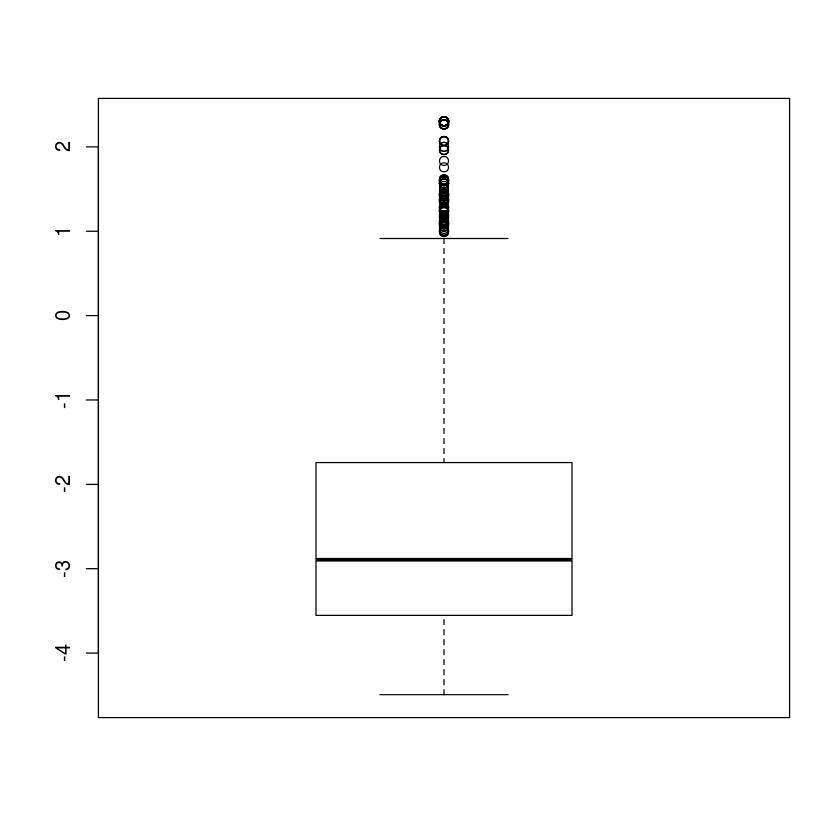

In [36]:
boxplot(log(dispersions(dds)))

## Differential Expression Analysis

We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [37]:
ddsDE<-DESeq(dds)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


We can get the results for the differential expression analysis using results()

In [38]:
myres<-results(ddsDE)

Let's look at the results for the first four genes

In [39]:
myres[1:4,]

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4 rows and 6 columns
          baseMean log2FoldChange     lfcSE       stat    pvalue      padj
         <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
gene0    13.063245     -0.3615293 0.4895581 -0.7384809 0.4602223 0.6225190
gene1   150.403062      0.1396895 0.1984781  0.7038029 0.4815555 0.6402232
gene10    3.611165      0.5992853 0.6890620  0.8697117 0.3844580 0.5526493
gene100  24.170850      0.2231204 0.3708345  0.6016711 0.5473931 0.6965989

You can get the descriptions for the columns from the DE analysis

In [40]:
data.frame(desc=mcols(myres)$description) 

desc
1 mean of normalized counts for all samples
2        log2 fold change (MAP): trt 8 vs 7
3                standard error: trt 8 vs 7
4                Wald statistic: trt 8 vs 7
5             Wald test p-value: trt 8 vs 7
6                      BH adjusted p-values

### P-values

One can extract the unadjusted p-values as follows

In [41]:
pvalues<-myres$pvalue
length(pvalues)
pvalues[1:4]

[1] 4444

[1] 0.4602223 0.4815555 0.3844580 0.5473931

The BH adjusted p-values can be extracted as

In [42]:
adjp<-myres$padj
length(adjp)
adjp[1:4]

[1] 4444

[1] 0.6225190 0.6402232 0.5526493 0.6965989

Calculate BH adjusted P-values by "hand" using the p.adjust() function. Note that you will not replicate the results you get under the padj column (when looking at the first four rows)

In [43]:
pvalues<-myres$pvalue
BH<-p.adjust(pvalues,"BH")
data.frame(BH=BH[1:4],adjp=adjp[1:4])

BH      adjp
1 0.6704050 0.6225190
2 0.6872980 0.6402232
3 0.6015538 0.5526493
4 0.7456737 0.6965989

The DESeq2::results function applies "independent" filtering. This enabled by default. Let's disable and the reexamine the adjusted P-values

In [44]:
myres1<-results(ddsDE,independentFiltering = FALSE)

In [45]:
myres1

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4444 rows and 6 columns
           baseMean log2FoldChange     lfcSE       stat     pvalue       padj
          <numeric>      <numeric> <numeric>  <numeric>  <numeric>  <numeric>
gene0     13.063245     -0.3615293 0.4895581 -0.7384809 0.46022230 0.67040501
gene1    150.403062      0.1396895 0.1984781  0.7038029 0.48155550 0.68729798
gene10     3.611165      0.5992853 0.6890620  0.8697117 0.38445797 0.60155379
gene100   24.170850      0.2231204 0.3708345  0.6016711 0.54739307 0.74567369
gene1000   7.675704     -1.1913393 0.5487654 -2.1709447 0.02993535 0.08914359
...             ...            ...       ...        ...        ...        ...
gene995   1.6197713      1.4706212 0.8162744  1.8016261 0.07160425 0.17719995
gene996  12.8488020     -0.2319250 0.4424331 -0.5242035 0.60013703 0.78035966
gene997   9.9461848     -1.0929507 0.4962577 -2.2023856 0.02763808 0.08386863
gene998  36.7337608     -0.2205173 0

We can now replicate the results

In [46]:
pvalues1<-myres1$pvalue
BH1<-p.adjust(pvalues1[!is.na(pvalues)],"BH")
data.frame(BH=BH1[1:4],adjp=myres1$padj[1:4])

BH      adjp
1 0.6704050 0.6704050
2 0.6872980 0.6872980
3 0.6015538 0.6015538
4 0.7456737 0.7456737

### Subset and reorder the results

In [47]:
summary(myres,0.05)


out of 4314 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 615, 14% 
LFC < 0 (down)   : 685, 16% 
outliers [1]     : 8, 0.19% 
low counts [2]   : 501, 12% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



You can sort the results by say the unadjusted P-values

In [48]:
myres[order(myres[["pvalue"]])[1:4],]


log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat        pvalue          padj
         <numeric>      <numeric> <numeric> <numeric>     <numeric>     <numeric>
gene1209 1110.3199      -3.347158 0.1492045 -22.43336 1.860541e-111 7.079359e-108
gene4405  436.6800       4.443710 0.2144262  20.72373  2.116499e-95  4.026639e-92
gene3312  488.4901       4.659130 0.2362760  19.71902  1.480824e-86  1.878178e-83
gene3317  322.3925       5.043525 0.2597286  19.41844  5.390243e-84  5.127469e-81

To get the list of genes with unadjusted P-values < 0.00001 and absolute log2 FC of more than 4

In [49]:
subset(myres,pvalue<0.00001&abs(log2FoldChange)>4)

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 24 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat       pvalue         padj
         <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
gene1300 175.91020       4.761123 0.4248758  11.20592 3.813880e-29 3.023294e-27
gene2034 128.44386       4.061622 0.3738799  10.86344 1.721393e-27 1.235830e-25
gene2127  82.92247       4.353625 0.3826230  11.37837 5.359438e-30 4.338864e-28
gene2128 120.48719       4.474566 0.3303883  13.54335 8.673550e-42 1.434907e-39
gene2179 436.50102       5.055035 0.2805605  18.01763 1.416826e-72 1.078204e-69
...            ...            ...       ...       ...          ...          ...
gene4405 436.68000       4.443710 0.2144262 20.723727 2.116499e-95 4.026639e-92
gene585   27.68248       5.127728 0.6402093  8.009455 1.152179e-15 3.535517e-14
gene594  121.06565       5.862144 0.4591564 12.767207 2.499646e-37 3.396840e-35
gene595  106.318

To get the list of genes with unadjusted P-values < 0.00001 and upregulated genes with log2 FC of more than 4

In [50]:
subset(myres,pvalue<0.00001&log2FoldChange>4)

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 24 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat       pvalue         padj
         <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
gene1300 175.91020       4.761123 0.4248758  11.20592 3.813880e-29 3.023294e-27
gene2034 128.44386       4.061622 0.3738799  10.86344 1.721393e-27 1.235830e-25
gene2127  82.92247       4.353625 0.3826230  11.37837 5.359438e-30 4.338864e-28
gene2128 120.48719       4.474566 0.3303883  13.54335 8.673550e-42 1.434907e-39
gene2179 436.50102       5.055035 0.2805605  18.01763 1.416826e-72 1.078204e-69
...            ...            ...       ...       ...          ...          ...
gene4405 436.68000       4.443710 0.2144262 20.723727 2.116499e-95 4.026639e-92
gene585   27.68248       5.127728 0.6402093  8.009455 1.152179e-15 3.535517e-14
gene594  121.06565       5.862144 0.4591564 12.767207 2.499646e-37 3.396840e-35
gene595  106.318

The P-values for the four top genes are beyond machine precision. You can use the format.pval() function to properly format the P-values. PLEASE promote ending the practice of publishing P-values below machine precision.  (that would be akin to stating the weight of an object that weighs less than one pound with scale that whose minimum weight spec is 1lbs).

In [51]:
myres$pval=format.pval(myres$pvalue)
myres[order(myres[["pvalue"]])[1:4],]

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4 rows and 7 columns
          baseMean log2FoldChange     lfcSE      stat        pvalue          padj        pval
         <numeric>      <numeric> <numeric> <numeric>     <numeric>     <numeric> <character>
gene1209 1110.3199      -3.347158 0.1492045 -22.43336 1.860541e-111 7.079359e-108  < 2.22e-16
gene4405  436.6800       4.443710 0.2144262  20.72373  2.116499e-95  4.026639e-92  < 2.22e-16
gene3312  488.4901       4.659130 0.2362760  19.71902  1.480824e-86  1.878178e-83  < 2.22e-16
gene3317  322.3925       5.043525 0.2597286  19.41844  5.390243e-84  5.127469e-81  < 2.22e-16

Let's look at a volcano plot

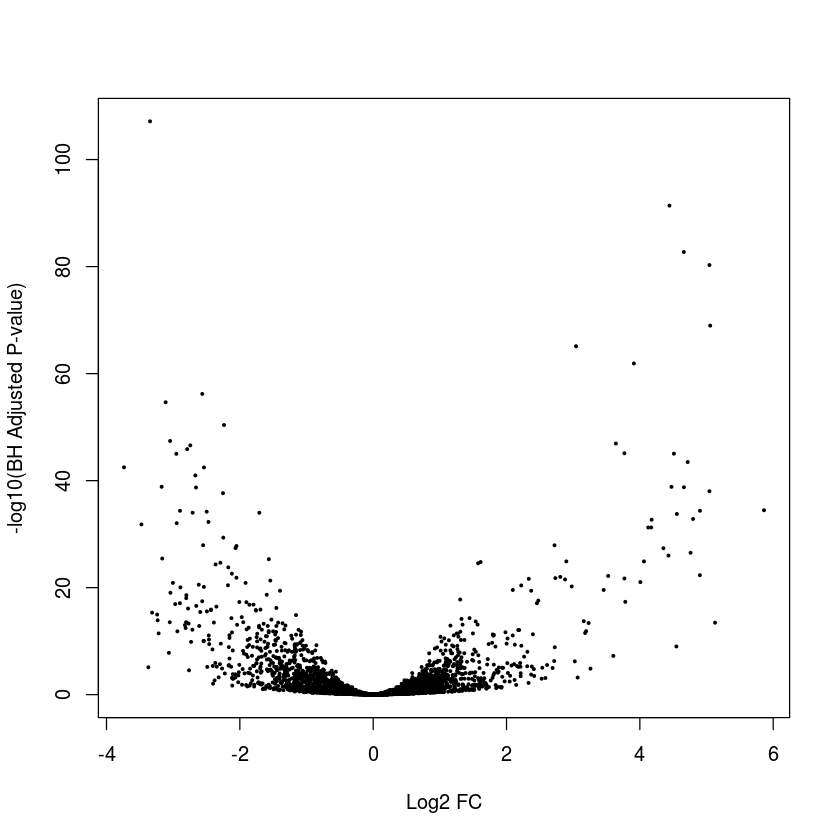

In [52]:
plot(myres$log2FoldChange,-log10(myres$padj),pch=19,cex=0.3,xlab="Log2 FC",ylab="-log10(BH Adjusted P-value)")

Extract results for genes GeneID:12932226 and GeneID:12930116

In [53]:
myres[c("gene3317","gene10"),]

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 2 rows and 7 columns
           baseMean log2FoldChange     lfcSE       stat       pvalue         padj        pval
          <numeric>      <numeric> <numeric>  <numeric>    <numeric>    <numeric> <character>
gene3317 322.392539      5.0435248 0.2597286 19.4184401 5.390243e-84 5.127469e-81  < 2.22e-16
gene10     3.611165      0.5992853 0.6890620  0.8697117 3.844580e-01 5.526493e-01  0.38445797

Exercise: Annotate the hits with adjusted P-values < 0.05 and absolute log2 FC greater than 2 in red

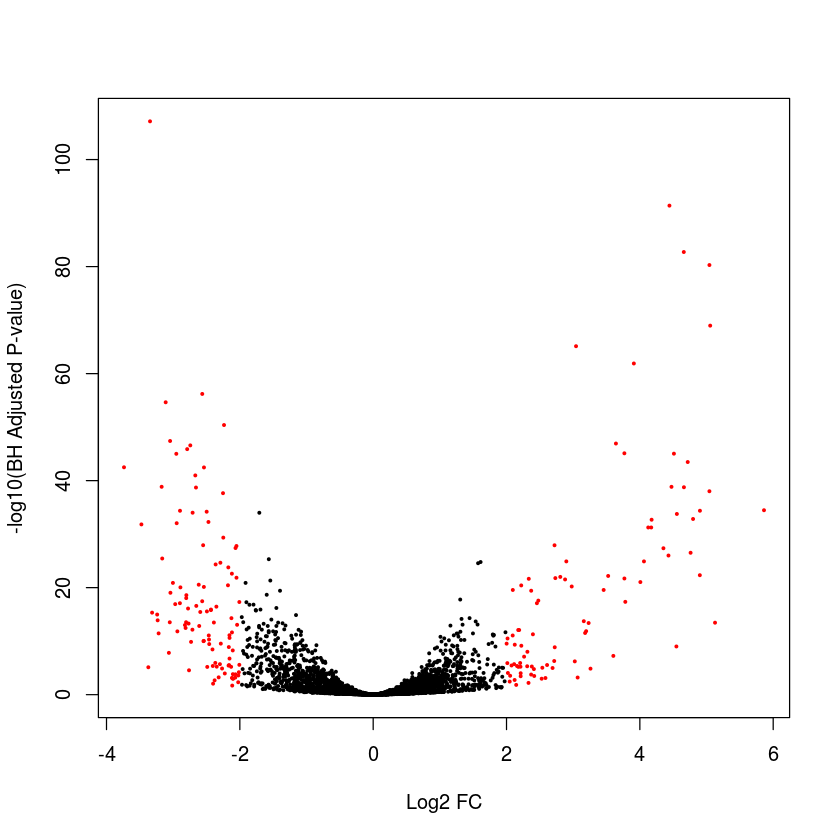

In [54]:
plot(myres$log2FoldChange,-log10(myres$padj),pch=19,cex=0.3,xlab="Log2 FC",ylab="-log10(BH Adjusted P-value)",col=ifelse(myres$padj<0.05&abs(myres$log2FoldChange)>2,"red","black"))

## Converting/Normalizing Counts to "Expressions" 

### Normalized Counts

We have already shown how to "normalize" the counts using the estimated size factors

In [55]:
head(counts(dds,normalize=TRUE),3)

7A_E       7B_E       7C_E       8A_E       8B_E       8C_E
gene0   11.046885  13.949554  19.331230  19.198464   6.946801   7.906535
gene1  132.562617 138.333073 157.702138 176.443026 142.409428 154.968093
gene10   3.682295   2.324926   2.034866   5.485275   2.605051   5.534575

Plot the counts stratified by treatment for the 2nd gene

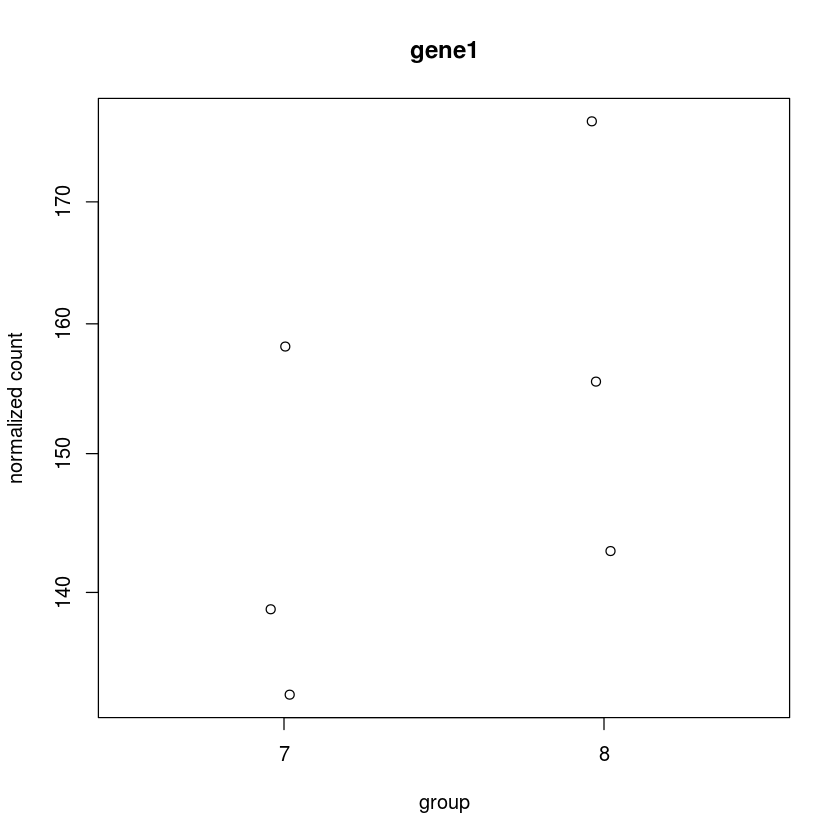

In [56]:
 plotCounts(dds, 2,intgroup="trt")

Or alternatively (better)

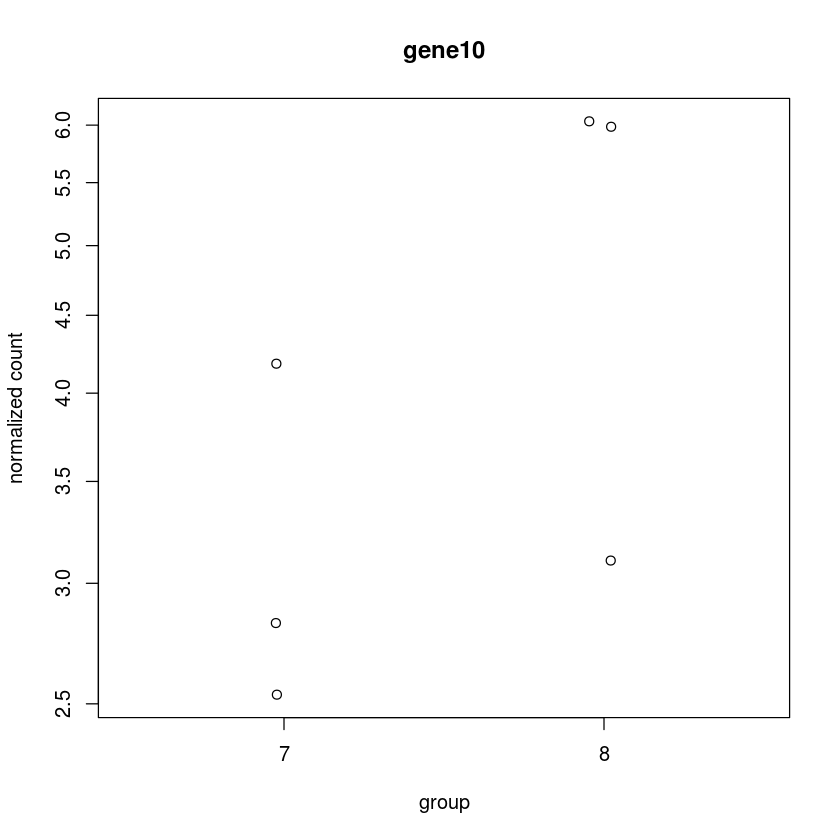

In [57]:
 plotCounts(dds, "gene10",intgroup="trt")

Now get this plot for the top hit

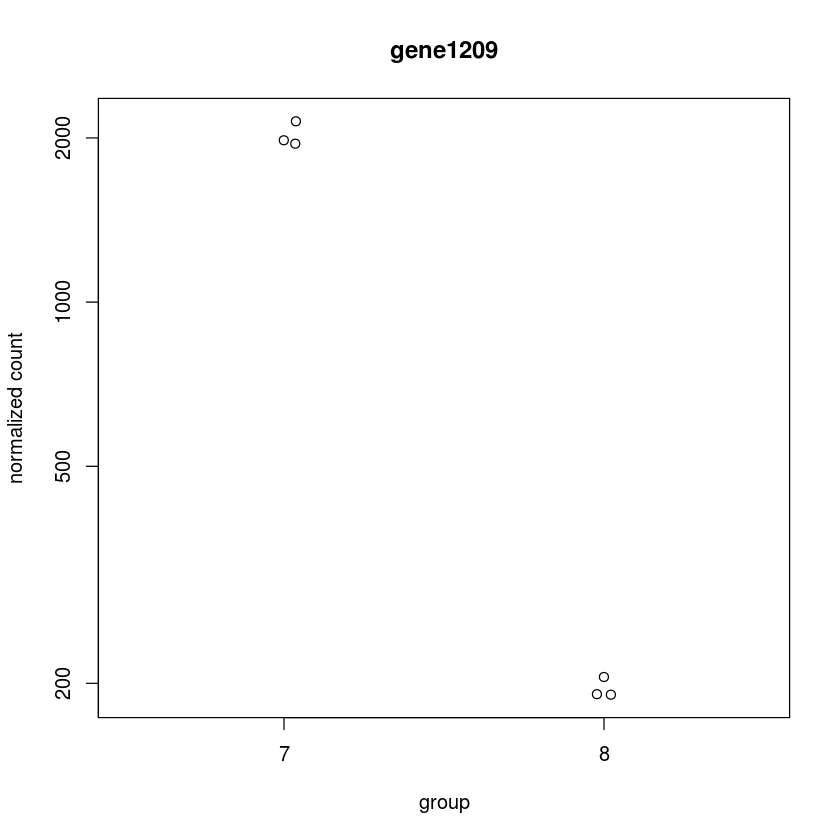

In [58]:
plotCounts(dds, "gene1209",intgroup="trt")

### FPM

Another approach is to FPM: fragments per million mapped fragments

In [59]:
head(fpm(dds),3)

7A_E      7B_E       7C_E      8A_E      8B_E       8C_E
gene0   7.563666  9.551087  13.235854  13.14495  4.756389   5.413507
gene1  90.763986 94.714946 107.976706 120.80836 97.505976 106.104739
gene10  2.521222  1.591848   1.393248   3.75570  1.783646   3.789455

Let's calculate the FPM manually. For gene $i$ sample $j$, the FPM is defined as $\frac{K_{ij}}{D_j}\times 10^{6}$ where $D_j=\sum_{i=1} K_{ij}$ is the read depth for sample $j$. First get the read depth for each sample

In [60]:
D<-colSums(counts(dds))
D

7A_E    7B_E    7C_E    8A_E    8B_E    8C_E 
1224153 1294576 1493765 1492923 1581586 1736478

By default, the fpm() function uses a robust approach. We will disable this right now as to replicate the standard FPM. Let's look at gene 1

In [61]:
fpm1<-fpm(dds,robust=FALSE)[1,]
fpm1

7A_E      7B_E      7C_E      8A_E      8B_E      8C_E 
 7.352022  9.269444 12.719538 14.066365  5.058214  5.758783

Now get the raw counts for gene 1

In [62]:
cnt1<-counts(dds)[1,]
cnt1

7A_E 7B_E 7C_E 8A_E 8B_E 8C_E 
   9   12   19   21    8   10

Now calculate the FPM for gene 1

In [63]:
myfpm1<-cnt1/D*1e6
myfpm1

7A_E      7B_E      7C_E      8A_E      8B_E      8C_E 
 7.352022  9.269444 12.719538 14.066365  5.058214  5.758783

This is how you check if two numeric columns are "equal"? One approach is to calculate the maximum absoute difference

In [64]:
max(abs(fpm1-myfpm1))

[1] 0

The above approach is also helpful in establishing if the difference is "small". Another approach to test for equality to use the all.equal() function

In [65]:
all.equal(fpm1,myfpm1)

[1] TRUE

It is generally a bad idea to compare numeric vectors using == (e.g., fpm1==myfpm1)

### FPKM

To calculate the FPKM (fragments per kilobase per million mapped fragments) we need to add annotation to assign the feature lengths. More specifically, for gene $i$ sample $j$, the FPKM is defined as $\frac{K_{ij}}{\ell_i D_j}\times 10^3 \times 10^{6}$ where $\ell_i$ is the "length" of gene $i$ (fragments for each $10^3$ bases in the gene for every  $\frac{D_j}{10^6}$ fragments. More on this later.

### Regularized log transformation

The regularized log transform can be obtained using the rlog() function. Note that an important argument for this function is blind (TRUE by default). The default "blinds" the normalization to the design. This is very important so as to not bias the analyses (e.g. class discovery)

In [66]:
rld<-rlog(dds,blind=TRUE)

Hierarchical clustering using rlog transformation

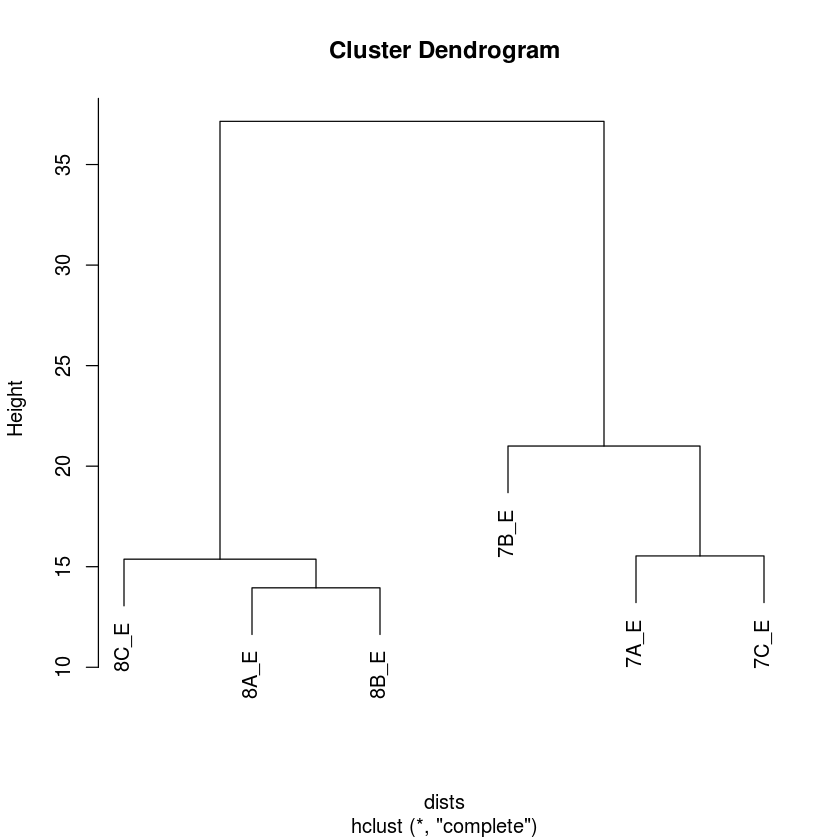

In [67]:
dists<-dist(t(assay(rld)))
plot(hclust(dists))

PC Analysis using the rlog transformation

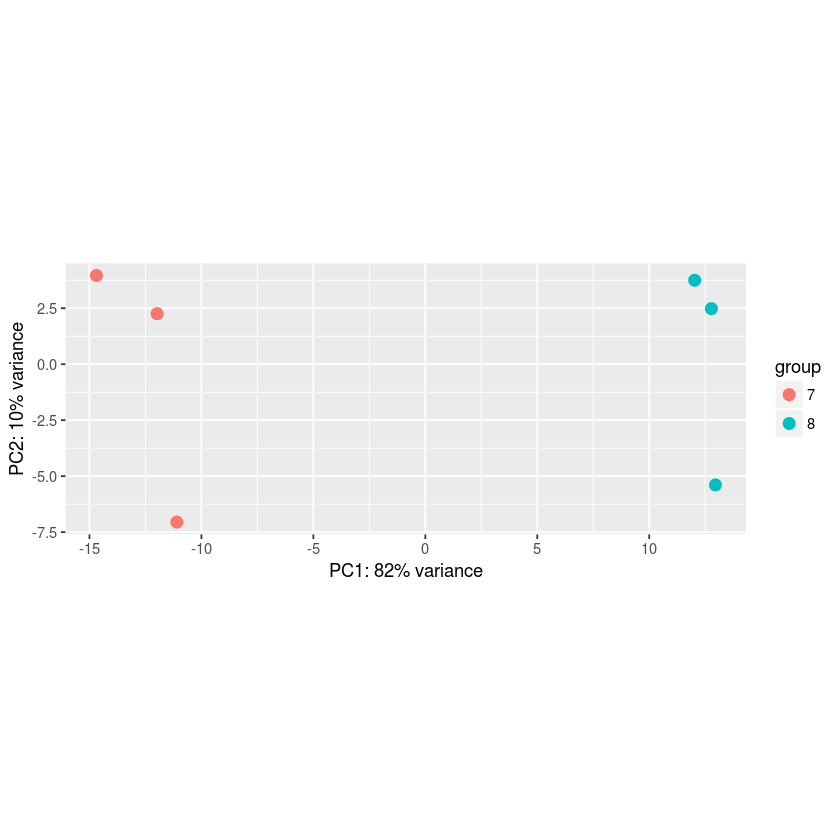

In [68]:
 plotPCA(rld,intgroup="trt")

### Variance Stabilizing Transformation (vst) and mean-variance modelling at the observational level (voom)

Two other normalization approaches for RNA-Seq count data are provided by the functions DESeq2::vst and limma::voom (note that for the latter one needs the limma package).


From ? DESeq2::vst
"This function calculates a variance stabilizing transformation (VST) from the fitted dispersion-mean relation(s) and then transforms the count data (normalized by division by the size factors or normalization factors), yielding a matrix of values which are now approximately homoskedastic (having constant variance along the range of mean values). The transformation also normalizes with respect to library size."

Compared to DESeq2::rlog
"The ‘rlog’ is less sensitive to size factors, which can be an issue when size factors vary widely. These transformations are useful when checking for outliers or as input for machine learning techniques such as clustering or linear discriminant analysis."


From ? limma::voom
"Transform count data to log2-counts per million (logCPM), estimate the mean-variance relationship and use this to compute appropriate observation-level weights. The data are then ready for linear modelling."

Get VST transformation

In [69]:
VST<-vst(dds)
class(VST)

[1] "DESeqTransform"
attr(,"package")
[1] "DESeq2"

Get the VST matrix

In [70]:
VSTmat<-assay(VST)
dim(VSTmat)
VSTmat[1:10,]

[1] 4444    6

7A_E      7B_E     7C_E     8A_E     8B_E     8C_E
gene0     3.923730  4.180475 4.559309 4.551088 3.452826 3.578618
gene1     7.097850  7.157394 7.340988 7.498825 7.198022 7.316447
gene10    2.901962  2.572007 2.486853 3.234850 2.648356 3.242828
gene100   5.077572  4.083261 4.843068 4.809872 4.964222 4.998826
gene1000  4.143823  3.978753 3.607448 3.077093 2.856875 3.108463
gene1001  2.203473  2.859947 2.760425 3.077093 2.856875 3.108463
gene1002  5.446930  5.335202 4.736260 4.945204 4.175947 4.678644
gene1003  6.680922  6.914822 6.352627 6.582342 6.552185 6.574850
gene1004  2.203473  1.155868 2.113095 2.064865 1.155868 2.003037
gene1005 10.071462 10.519630 9.903560 8.758925 9.039811 8.859864

Get voom transformation (note that according to ? limma::voom, the function is expecting raw counts

In [71]:
VOOM<-limma::voom(counts(dds))

Get the VOOM matrix

In [72]:
VOOMmat<-VOOM$E
dim(VOOMmat)
VOOMmat[1:10,]

[1] 4444    6

7A_E       7B_E        7C_E        8A_E      8B_E       8C_E
gene0    2.9561425  3.2713754 3.706448053 3.848124030  2.426090  2.5961525
gene1    6.4697662  6.5283860 6.701816604 7.018049032  6.700571  6.8222205
gene10   1.5155699  0.9494473 0.742973929 2.122298994  1.145982  2.1107256
gene100  4.3229248  3.1510812 4.035755678 4.149779730  4.315907  4.3535822
gene1000 3.2317769  3.0198366 2.508508675 1.881290894  1.508552  1.9042748
gene1001 0.2931774  1.4348741 1.228400756 1.881290894  1.508552  1.9042748
gene1002 4.7305828  4.6047991 3.912898930 4.304502325  3.383021  3.9851947
gene1003 6.0391318  6.2785709 5.678433677 6.072910967  6.032114  6.0555841
gene1004 0.2931774 -1.3724808 0.006008335 0.006821776 -1.661373 -0.2112025
gene1005 9.4788788  9.9261546 9.293720714 8.296840623  8.571048  8.3899493

### Get Session Information

In [73]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8       
 [4] LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                  LC_ADDRESS=C              
[10] LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils     datasets  methods  
[10] base     

other attached packages:
 [1] dplyr_0.5.0                qvalue_2.6.0               limma_3.30.13             
 [4] DESeq2_1.14.1              SummarizedExperiment_1.4.0 Biobase_2.34.0            
 [7] GenomicRanges_1.26.4       GenomeInfoDb_1.10.3        IRanges_2.8.2             
[10] S4Vectors_0.12.2           BiocGenerics_0.20.0       

loaded via a namespace (and not attached):
 [1] locfit_1.